# APPENDIX A

# 1. Software used

All data management was done in MS Access, using SQL queries to extract relevant information. Data analysis was performed in R, and all mapping in QGIS. For the aoristic analysis, a Python script was employed.


# 2. Data used

## 2.1 Settlements

The settlement data used are all stored on https://github.com/LimesLimits/Archaeological-data. These data were compiled within the framework of the *Finding the Limits of the Limes* project [(Verhagen *et al.* 2019)](https://link.springer.com/book/10.1007/978-3-030-04576-0) from publicly available datasets and literature, in particular through [ARCHIS](https://archis.cultureelerfgoed.nl) and [DANS Easy](https://easy.dans.knaw.nl). In order to harmonize the data, the ARCHIS2 database structure was used, which distinguishes between individual finds and observations (collections of finds at a single location), and uses standardized vocabularies for chronology and find types. A description of the ARCHIS2 database structure (in Dutch) is added, since there is no public domain resource available for this anymore.

The registered observations were grouped into archaeological sites when 10 or more Roman period finds were reported within a 250 m radius of each other. The sites were then classified into functional groups, based on the find material and interpretations given in archaeological reports. The large majority of observed sites was classified as "rural settlement", and these are the sites used for the analysis presented in this paper. However, various other categories were distinguished, including cemeteries, cult sites, infrastructure, civil settlements and military forts.

For more information on the nature and quality of the archaeological data, see [Verhagen *et al.* (2016)](https://doi.org/10.1016/j.jasrep.2016.10.006).

## 2.2 Palaeogeographic map

The palaeogeographic map of the study region in the Roman period was compiled by Mark R. Groenhuijzen for his PhD thesis (Groenhuijzen 2018) and is available at https://github.com/LimesLimits/Palaeogeography.
<hr>

# 3. Aoristic analysis

Following the procedures outlined in Verhagen *et al.* (2016), the aoristic analysis was run on the full site dataset as compiled by August 2019. As the original publication did not include an Open Source deposit of the Python script used, this is now made available on https://github.com/LimesLimits/aoristic-analysis.

The results of the analysis are stored in two datafiles: `sim_res_sum.txt` and `sim_res_cum.txt`. The first one registers how many times an observation has been dated to a specific ARCHIS2 subperiod. The second one reports the cumulative count, which is useful when applying a cut-off point such as was done for this study. 

The dataset was subdivided into the main archaeological periods distinguished, assuming there to be sufficient evidence of occupation if 10 finds were placed in a particular period in more than 500 out of the 1000 simulations. The resulting files are named [`ASUM_IJZL.txt`](./ASUM_IJZL.txt), [`ASUM_ROMV.txt`](./ASUM_ROMV.txt), [`ASUM_ROMM.txt`](./ASUM_ROMM.txt) and [`ASUM_ROML.txt`](./ASUM_ROML.txt).

In [1]:
options(warn = -1) 

# read data files into R

ASUM_IJZL <- read.csv("./ASUM_IJZL.txt", header=TRUE, sep=";")
ASUM_ROMV <- read.csv("./ASUM_ROMV.txt", header=TRUE, sep=";")
ASUM_ROMM <- read.csv("./ASUM_ROMM.txt", header=TRUE, sep=";")
ASUM_ROML <- read.csv("./ASUM_ROML.txt", header=TRUE, sep=";")

head(ASUM_IJZL)

,LimesLimits_ID,X_coordinate,Y_coordinate,Place,Toponym,Site_type,Nb_finds,Nb_runs_IJZL
,<int>,<int>,<int>,<chr>,<chr>,<chr>,<int>,<int>
1,1,179520,417600,Escharen,Graafsche Raam,rural settlement,10,993
2,4,180500,417500,Escharen,Escharense Veld I,rural settlement; burial(s),10,1000
3,33,173600,416800,Schaijk,Kleefsestraat,rural settlement,10,1000
4,37,171650,423750,Deursen,Het Steenwerk,rural settlement; burial(s),10,1000
5,39,170600,423900,Deursen,De Woerden,rural settlement,10,712
6,40,170100,422950,Deursen,Onze Lieve Vrouwenberg,rural settlement,10,1000


# 4. Sites per period

Figure 2 in Section 2 shows the number of sites per period, visualised using the [ggplot2()](https://cran.r-project.org/web/packages/ggplot2/index.html) library in R.

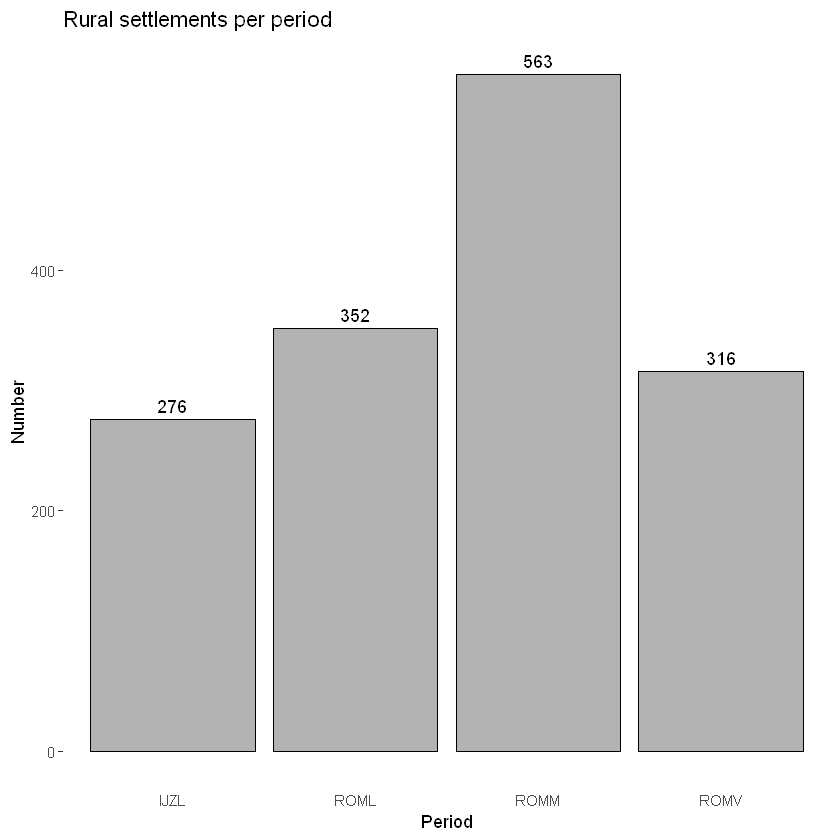

In [2]:
# script sites_per_period.R

# install.packages("ggplot2")
library(ggplot2)

# count numbers of sites per period and bind them together, convert numbers to numeric

N_PERIOD <- data.frame(rbind(c("IJZL",nrow(ASUM_IJZL)),c("ROMV",nrow(ASUM_ROMV)),c("ROMM",nrow(ASUM_ROMM)),c("ROML",nrow(ASUM_ROML))))
N_PERIOD$X2 <- as.numeric(as.character(N_PERIOD$X2))

# plot numbers of sites per period

ggplot(N_PERIOD, aes(X1, y = as.numeric(X2))) + 
  geom_col(fill="grey70", colour="black") +
  geom_text(aes(label = X2), vjust = -0.5) +
  ggtitle("Rural settlements per period") +
  xlab("Period") +
  ylab("Number") + 
  theme(panel.background = element_rect(fill="white")) +
  theme(axis.ticks.x=element_blank())

# 5. Nearest neighbour analysis

The nearest neighbour analysis (Section 2, Table 2 and Figure 3) was done using the [`spatstat()`](https://cran.r-project.org/web/packages/spatstat/) package (Baddeley 2022).

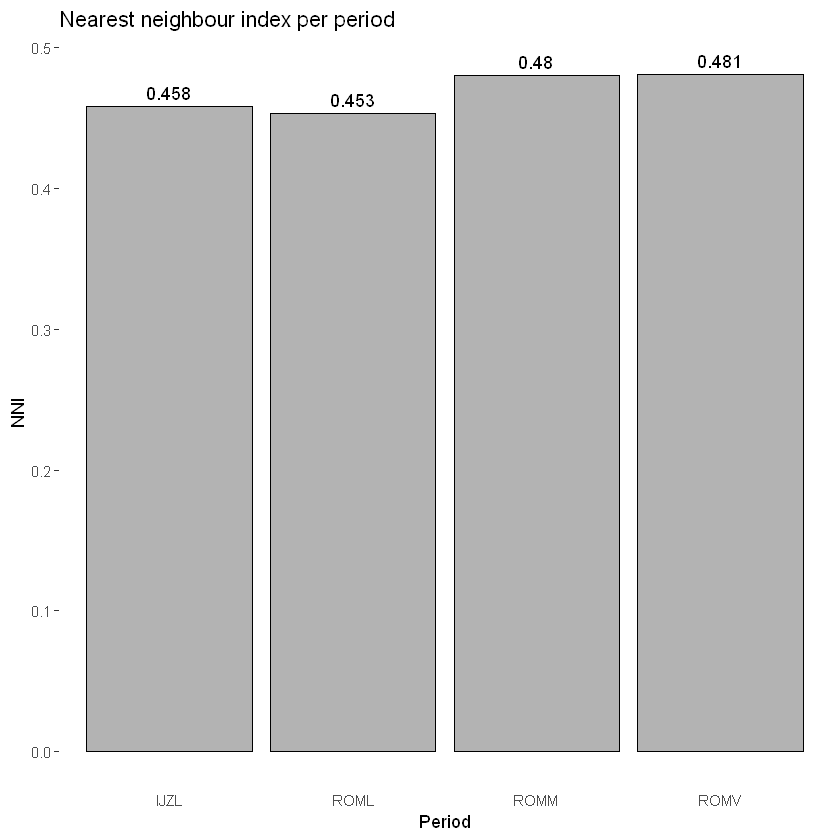

In [15]:
# script nni_per_period.R

# install.packages("spatstat")
library(spatstat)

# create point patterns from data files

# the extent of the study region is defined by xmin xmax ymin ymax, this can be adapted if needed

xmin <- 73241
xmax <- 203530
ymin <- 412375
ymax <- 483121

xrange <- c(xmin,xmax)
yrange <- c(ymin,ymax)
extent <- (xmax - xmin) * (ymax - ymin)

pp_IJZL <- ppp(ASUM_IJZL$X_coordinate,ASUM_IJZL$Y_coordinate,xrange,yrange)
pp_ROMV <- ppp(ASUM_ROMV$X_coordinate,ASUM_ROMV$Y_coordinate,xrange,yrange)
pp_ROMM <- ppp(ASUM_ROMM$X_coordinate,ASUM_ROMM$Y_coordinate,xrange,yrange)
pp_ROML <- ppp(ASUM_ROML$X_coordinate,ASUM_ROML$Y_coordinate,xrange,yrange)

# calculate nearest neighbour indices from point patterns

nni_IJZL = mean(nndist(pp_IJZL))/(0.5 * sqrt(extent / NROW(ASUM_IJZL)))
nni_ROMV = mean(nndist(pp_ROMV))/(0.5 * sqrt(extent / NROW(ASUM_ROMV)))
nni_ROMM = mean(nndist(pp_ROMM))/(0.5 * sqrt(extent / NROW(ASUM_ROMM)))
nni_ROML = mean(nndist(pp_ROML))/(0.5 * sqrt(extent / NROW(ASUM_ROML)))

# bind outcomes to single data frame and convert numbers to numeric

NNI_PERIOD <- data.frame(rbind(c("IJZL",nni_IJZL),c("ROMV",nni_ROMV),c("ROMM",nni_ROMM),c("ROML",nni_ROML)))
NNI_PERIOD$X2 <- as.numeric(as.character(NNI_PERIOD$X2))

# plot the results

ggplot(NNI_PERIOD, aes(X1, y = X2)) + 
  geom_col(fill="grey70", colour="black") +
  geom_text(aes(label = round(X2, digits = 3)), vjust = -0.5) +
  ggtitle("Nearest neighbour index per period") +
  xlab("Period") +
  ylab("NNI") + 
  theme(panel.background = element_rect(fill="white")) +
  theme(axis.ticks.x=element_blank())

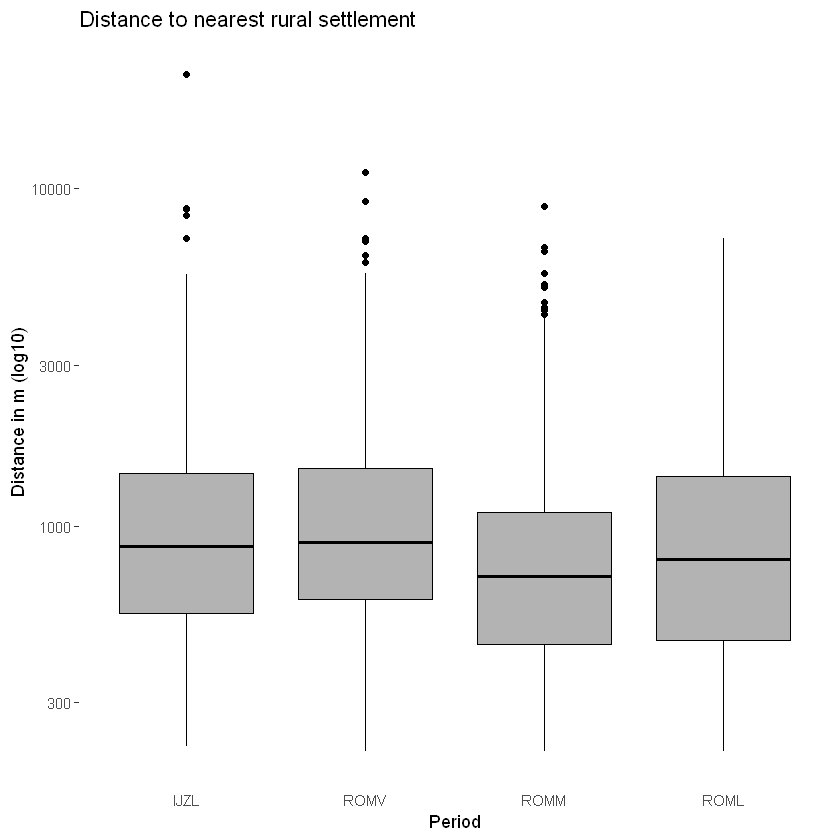

In [4]:
# script nn_per_period.R

# calculate nearest neighbour distance for all sites per period

nnd_IJZL <- data.frame(nnd = nndist(pp_IJZL))
nnd_IJZL$PERIOD <- "IJZL"
nnd_IJZL$order <- 1
nnd_ROMV <- data.frame(nnd = nndist(pp_ROMV))
nnd_ROMV$PERIOD <- "ROMV"
nnd_ROMV$order <- 2
nnd_ROMM <- data.frame(nnd = nndist(pp_ROMM))
nnd_ROMM$PERIOD <- "ROMM"
nnd_ROMM$order <- 3
nnd_ROML <- data.frame(nnd = nndist(pp_ROML))
nnd_ROML$PERIOD <- "ROML"
nnd_ROML$order <- 4

# bind the data

nnd_ALL <- rbind(nnd_IJZL,nnd_ROMV,nnd_ROMM,nnd_ROML)

# plot the results

ggplot(nnd_ALL, aes(as.character(order), nnd)) + 
  geom_boxplot(fill="grey70", colour="black") +
  ggtitle("Distance to nearest rural settlement") +
  scale_x_discrete(labels = c("IJZL", "ROMV", "ROMM", "ROML")) +
  scale_y_log10() +
  xlab("Period") +
  ylab("Distance in m (log10)") + 
  theme(panel.background = element_rect(fill="white")) +
  theme(axis.ticks.x=element_blank())

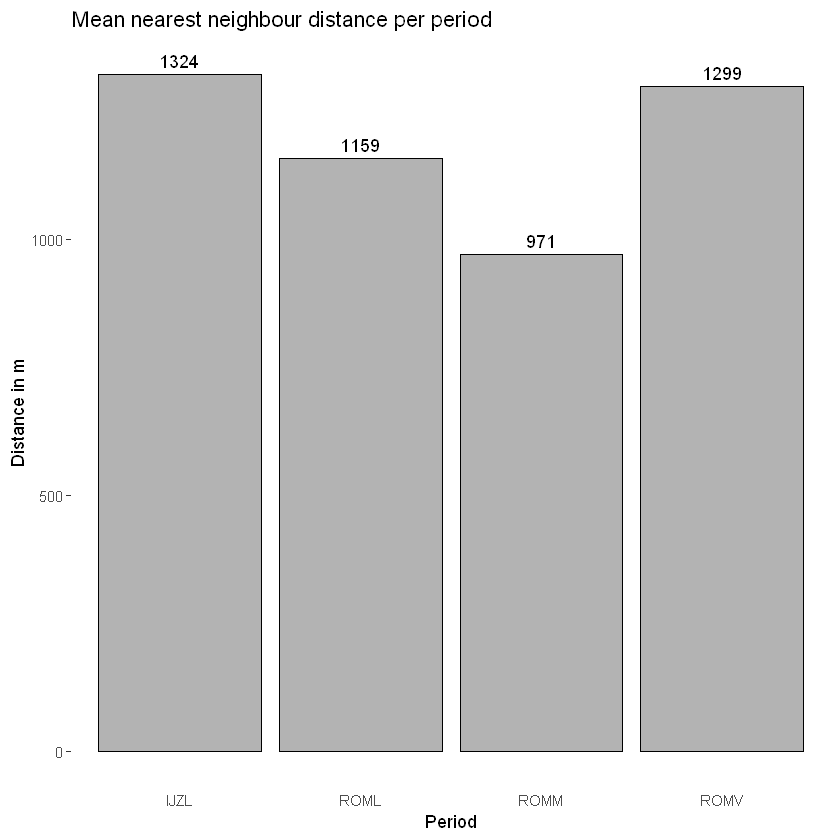

In [5]:
# script mean_nn_per_period.R

# calculate mean of nearest neighbour distances

mnn_IJZL = mean(nndist(pp_IJZL))
mnn_ROMV = mean(nndist(pp_ROMV))
mnn_ROMM = mean(nndist(pp_ROMM))
mnn_ROML = mean(nndist(pp_ROML))

# bind outcomes to single data frame, and convert number to numeric

MNN_PERIOD <- data.frame(rbind(c("IJZL",mnn_IJZL),c("ROMV",mnn_ROMV),c("ROMM",mnn_ROMM),c("ROML",mnn_ROML)))
MNN_PERIOD$X2 <- as.numeric(as.character(MNN_PERIOD$X2))

# plot the results

ggplot(MNN_PERIOD, aes(X1, y = X2)) + 
  geom_col(fill="grey70", colour="black") +
  geom_text(aes(label = round(X2, digits = 0)), vjust = -0.5) +
  ggtitle("Mean nearest neighbour distance per period") +
  xlab("Period") +
  ylab("Distance in m") + 
  theme(panel.background = element_rect(fill="white")) +
  theme(axis.ticks.x=element_blank())

# 6. Appearance and disappearance

Distances at which sites appear / disappear (Section 2, Figure 4) were determined as follows after selecting the newly appearing and disappearing settlements from the dataset and storing them in the files [`ASUM_ROMV_NEW.txt`](./ASUM_ROMV_NEW.txt), [`ASUM_ROMM_NEW.txt`](./ASUM_ROMM_NEW.txt) and [`ASUM_ROML_ABD.txt`](./ASUM_ROML_ABD.txt)

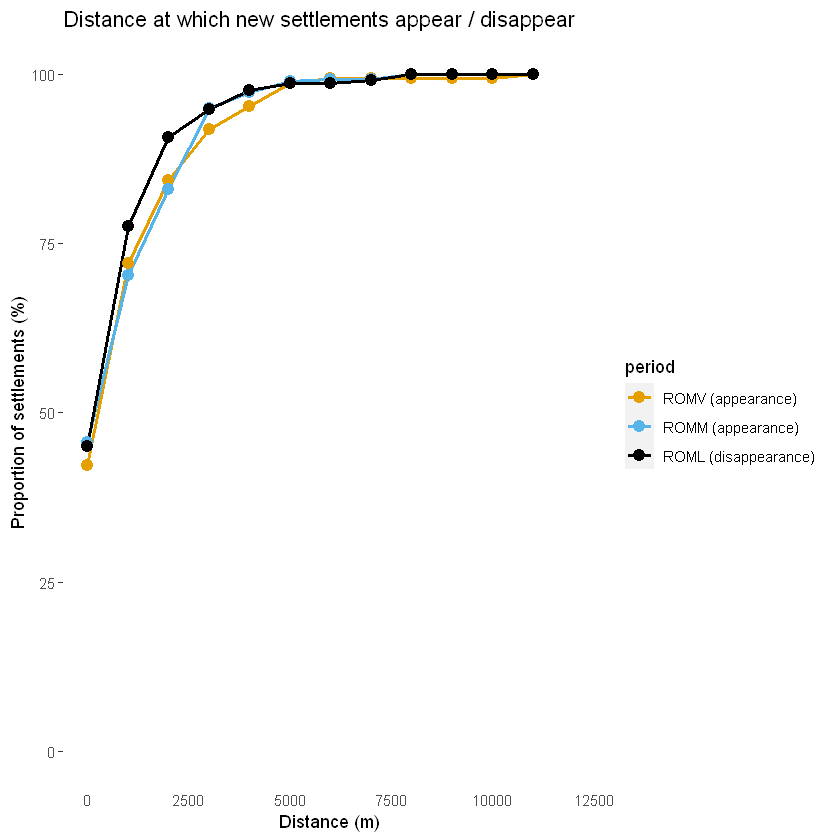

In [6]:
# script new_sites_per_period.R

# colour blind palette for plot

cbPalette <- c("#E69F00", "#56B4E9", "#000000", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7")

# read data files into R

ASUM_ROMV_NEW <- read.csv("./ASUM_ROMV_NEW.txt", header=TRUE, sep=";")
ASUM_ROMM_NEW <- read.csv("./ASUM_ROMM_NEW.txt", header=TRUE, sep=";")
ASUM_ROML_ABD <- read.csv("./ASUM_ROML_ABD.txt", header=TRUE, sep=";")

# create point pattern

pp_ROMV_NEW <- ppp(ASUM_ROMV_NEW$X_coordinate,ASUM_ROMV_NEW$Y_coordinate,xrange,yrange)
pp_ROMM_NEW <- ppp(ASUM_ROMM_NEW$X_coordinate,ASUM_ROMM_NEW$Y_coordinate,xrange,yrange)
pp_ROML_ABD <- ppp(ASUM_ROML_ABD$X_coordinate,ASUM_ROML_ABD$Y_coordinate,xrange,yrange)

# calculate nearest neighbour distances

nnd_ROMV_NEW <- nncross(pp_ROMV_NEW,pp_IJZL)
nnd_ROMM_NEW <- nncross(pp_ROMM_NEW,pp_ROMV)
nnd_ROML_ABD <- nncross(pp_ROML_ABD,pp_ROML)

# prepare data for the plot, making sure the settlement counts are converted to proportions

h1 <- hist(nnd_ROMV_NEW$dist,breaks=seq(0,12000,by=1000),plot=FALSE)
d1 <- data.frame(x = h1$breaks,y = c((100*h1$counts)/sum(h1$counts),NA))
c1 <- data.frame(x = h1$breaks,y = cumsum(d1$y))
h2 <- hist(nnd_ROMM_NEW$dist,breaks=seq(0,12000,by=1000),plot=FALSE)
d2 <- data.frame(x = h2$breaks,y = c((100*h2$counts)/sum(h2$counts),NA))
c2 <- data.frame(x = h2$breaks,y = cumsum(d2$y))
h3 <- hist(nnd_ROML_ABD$dist,breaks=seq(0,12000,by=1000),plot=FALSE)
d3 <- data.frame(x = h3$breaks,y = c((100*h3$counts)/sum(h3$counts),NA))
c3 <- data.frame(x = h2$breaks,y = cumsum(d3$y))

# plot distances of new / abandoned sites per period

ggplot() +
  geom_line(aes(x=x,y=y,colour="1"), size=1, c1) +
  geom_line(aes(x=x,y=y,colour="2"), size=1, c2) +
  geom_line(aes(x=x,y=y,colour="3"), size=1, c3) +
  geom_point(aes(x=x,y=y,colour="1"), size=3, c1) +
  geom_point(aes(x=x,y=y,colour="2"), size=3, c2) +
  geom_point(aes(x=x,y=y,colour="3"), size=3, c3) +
  ggtitle("Distance at which new settlements appear / disappear") +
  scale_colour_manual(values=cbPalette, name="period",labels=c("ROMV (appearance)","ROMM (appearance)","ROML (disappearance)")) +
  xlim(0,12000) +
  ylim(0,100) +
  xlab("Distance (m)") +
  ylab("Proportion of settlements (%)") +
  theme(panel.background = element_rect(fill="white")) +
  theme(axis.ticks.x=element_blank())

# 7. Percolation analysis

The percolation analysis was carried out using of [`percopackage()`](https://github.com/SCSchmidt/percopackage) (see [Maddison and Schmidt 2020)](http://doi.org/10.5334/jcaa.54). 

While `percopackage()` creates map images as outputs, the maps for the article were made using the resulting `.shp` files in QGIS (Section 2, Figure 5).

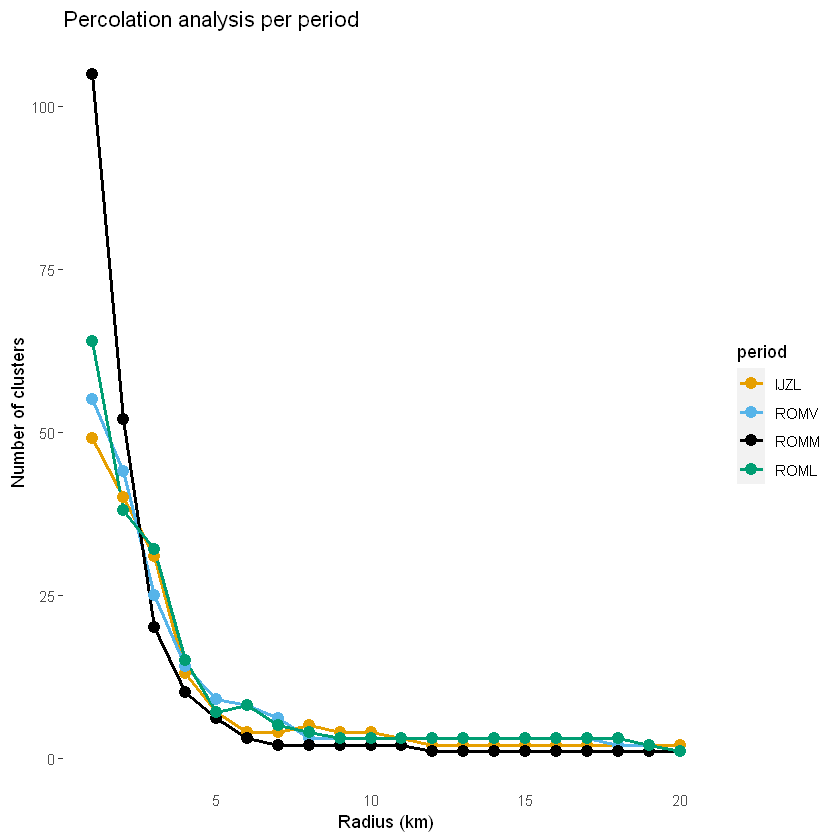

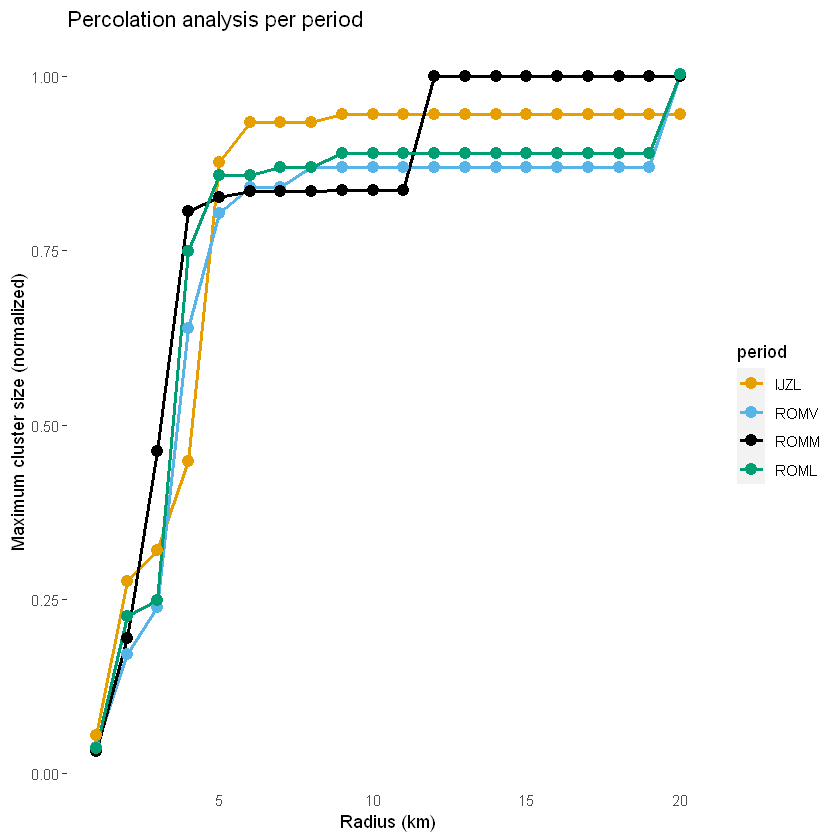

In [7]:
# script percolation.R

# uncomment to run percopackage() - this may take some time! 
# percopackage() will store the results in two folders, [maps] and [analysis_results]
# for the purpose of this appendix, the analyses have already been run

# install.packages("spatial", "percopackage")
# library(spatial)
# library(percopackage)

# create input files for percopackage

perco_IJZL <- as.data.frame(cbind(PlcIndex = ASUM_IJZL$LimesLimits_ID,Easting = ASUM_IJZL$X_coordinate,Northing = ASUM_IJZL$Y_coordinate))
perco_ROMV <- as.data.frame(cbind(PlcIndex = ASUM_ROMV$LimesLimits_ID,Easting = ASUM_ROMV$X_coordinate,Northing = ASUM_ROMV$Y_coordinate))
perco_ROMM <- as.data.frame(cbind(PlcIndex = ASUM_ROMM$LimesLimits_ID,Easting = ASUM_ROMM$X_coordinate,Northing = ASUM_ROMM$Y_coordinate))
perco_ROML <- as.data.frame(cbind(PlcIndex = ASUM_ROML$LimesLimits_ID,Easting = ASUM_ROML$X_coordinate,Northing = ASUM_ROML$Y_coordinate))

# runs percolation analysis per period
# MAKE SURE THAT YOU RENAME OR MOVE FILES IN THE FOLDER [analysis_results] after each run!

# percolate(perco_IJZL,NULL,20,1,1,20,1000)
# mapClusters(perco_map,"Late Iron Age","perco_IJZL")
# plotClustFreq()

# percolate(perco_ROMV,NULL,20,1,1,20,1000)
# mapClusters(perco_map,"Early Roman period","perco_ROMV")
# plotClustFreq()

# percolate(perco_ROMM,NULL,20,1,1,20,1000)
# mapClusters(perco_map,"Middle Roman period","perco_ROMM")
# plotClustFreq()

# percolate(perco_ROML,NULL,20,1,1,20,1000)
# mapClusters(perco_map,"Late Roman period","perco_ROML")
# plotClustFreq()

# import analysis results in R

analysis_by_radius_IJZL <- read.csv("./analysis_results/IJZL/analysis_by_radius.csv")
analysis_by_radius_ROMV <- read.csv("./analysis_results/ROMV/analysis_by_radius.csv")
analysis_by_radius_ROMM <- read.csv("./analysis_results/ROMM/analysis_by_radius.csv")
analysis_by_radius_ROML <- read.csv("./analysis_results/ROML/analysis_by_radius.csv")

# plot the results as number of clusters and normalized maximum cluster size per radius

ggplot() +
geom_line(aes(radius, num_clust, colour="1"), size = 1, analysis_by_radius_IJZL) +
geom_line(aes(radius, num_clust, colour="2"), size = 1, analysis_by_radius_ROMV) +
geom_line(aes(radius, num_clust, colour="3"), size = 1, analysis_by_radius_ROMM) +
geom_line(aes(radius, num_clust, colour="4"), size = 1, analysis_by_radius_ROML) +
geom_point(aes(radius, num_clust, colour="1"), size = 3, analysis_by_radius_IJZL) +
geom_point(aes(radius, num_clust, colour="2"), size = 3, analysis_by_radius_ROMV) +
geom_point(aes(radius, num_clust, colour="3"), size = 3, analysis_by_radius_ROMM) +
geom_point(aes(radius, num_clust, colour="4"), size = 3, analysis_by_radius_ROML) +
ggtitle("Percolation analysis per period") +
scale_colour_manual(values=cbPalette, name="period",labels=c("IJZL","ROMV","ROMM","ROML")) +
xlab("Radius (km)") +
ylab("Number of clusters") +
theme(panel.background = element_rect(fill="white")) +
theme(axis.ticks.x=element_blank())

ggplot() +
  geom_line(aes(radius, max_normalized, colour="1"), size = 1, analysis_by_radius_IJZL) +
  geom_line(aes(radius, max_normalized, colour="2"), size = 1, analysis_by_radius_ROMV) +
  geom_line(aes(radius, max_normalized, colour="3"), size = 1, analysis_by_radius_ROMM) +
  geom_line(aes(radius, max_normalized, colour="4"), size = 1, analysis_by_radius_ROML) +
  geom_point(aes(radius, max_normalized, colour="1"), size = 3, analysis_by_radius_IJZL) +
  geom_point(aes(radius, max_normalized, colour="2"), size = 3, analysis_by_radius_ROMV) +
  geom_point(aes(radius, max_normalized, colour="3"), size = 3, analysis_by_radius_ROMM) +
  geom_point(aes(radius, max_normalized, colour="4"), size = 3, analysis_by_radius_ROML) +
  ggtitle("Percolation analysis per period") +
  scale_colour_manual(values=cbPalette, name="period",labels=c("IJZL","ROMV","ROMM","ROML")) +
  xlab("Radius (km)") +
  ylab("Maximum cluster size (normalized)") +
  theme(panel.background = element_rect(fill="white")) +
  theme(axis.ticks.x=element_blank())

# 8. Hierarchical classification

## 8.1 Building materials and imported ceramics

The hierarchical classification of settlements is based on the presence / absence of specific combinations of building materials and imported ceramics, as explained in the paper. The underlying data files are named [`BM_ALLSITES.txt`](./BM_ALLSITES.txt) for the building materials, and [`IMP_ALLSITES.txt`](./IMP_ALLSITES.txt) for the imports, and contains the results of SQL queries in MS Access for numbers of finds per site. These were then used to create the hierarchical classification.

The analysis presented was carried out using the [data.table()](https://cran.r-project.org/web/packages/data.table/index.html) package.

First, a selection was made from the dataset listing all combination of building materials and imported ceramics (Section 3, Tables 3 and 4, Figures 6 and 7).

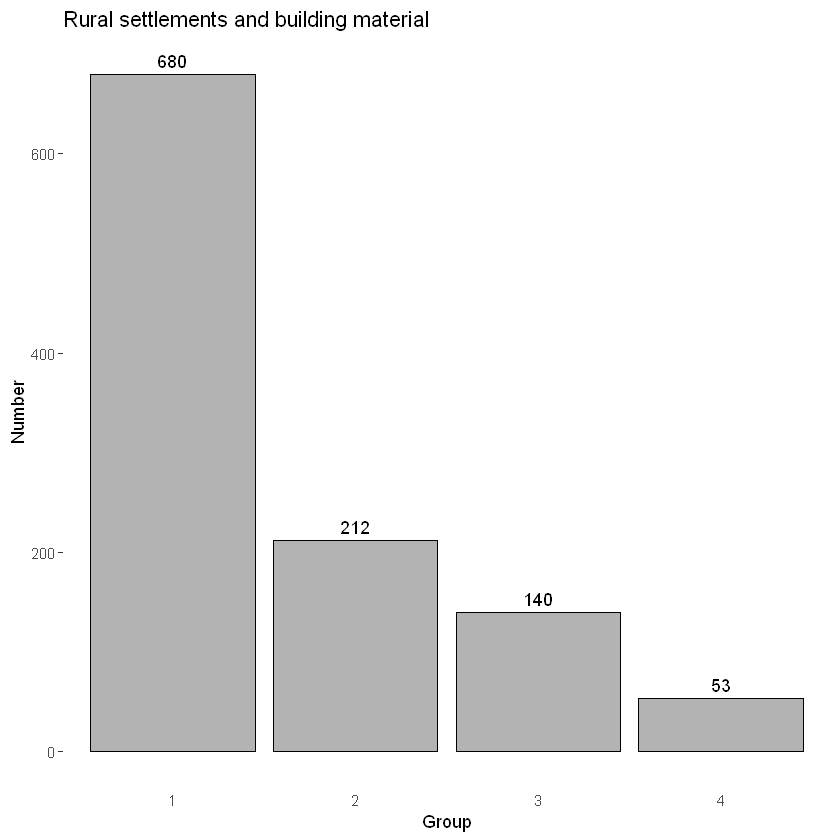

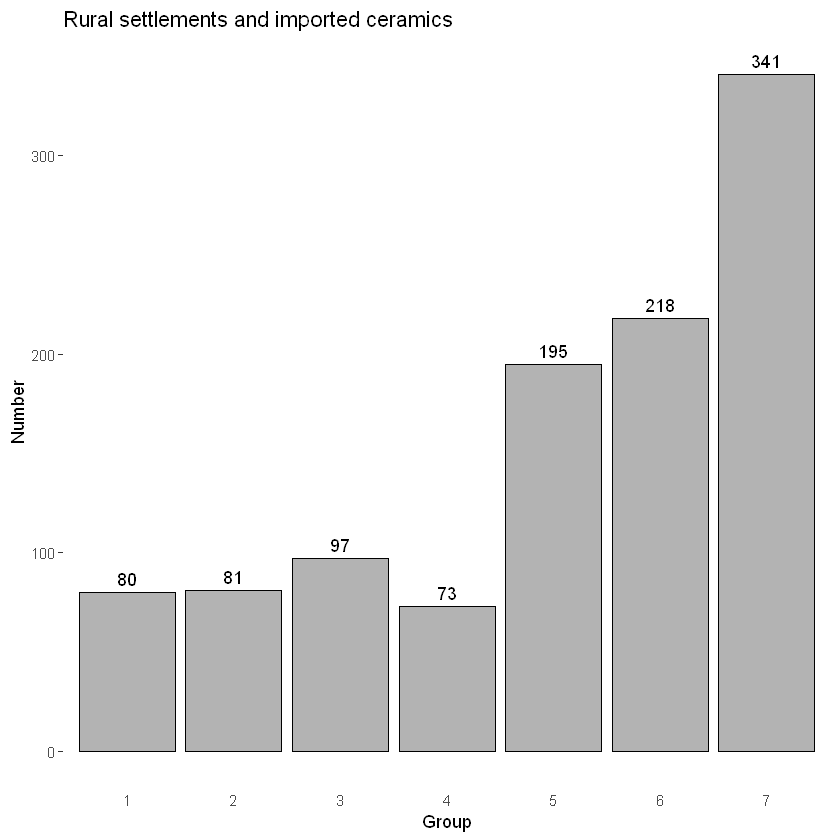

In [16]:
# script bm_imp_cnt.R

#install.packages("data.table")
library(data.table)

# read the datafiles

BM_ALLSITES <- read.csv("./BM_ALLSITES.txt", header=TRUE, sep=";")
IMP_ALLSITES <- read.csv("./IMP_ALLSITES.txt", header=TRUE, sep=";", fileEncoding = "utf16")

# first select all rural settlements using the data.table() package

rural_bm <- subset(BM_ALLSITES, Site_type %like% "rural")
rural_imp <- subset(IMP_ALLSITES, Site_type %like% "rural")

# tabulate the totals per group

rbm_cnt <- table(rural_bm$BM_GROUP)
rimp_cnt <- table(rural_imp$IMP_GROUP)

# plot the results

ggplot(as.data.frame(rbm_cnt), aes(Var1, Freq)) + 
  geom_col(fill="grey70", colour="black") +
  geom_text(aes(label = Freq, vjust = -0.5)) +
  ggtitle("Rural settlements and building material") +
  xlab("Group") +
  ylab("Number") + 
  theme(panel.background = element_rect(fill="white")) +
  theme(axis.ticks.x=element_blank())

ggplot(as.data.frame(rimp_cnt), aes(Var1, Freq)) + 
  geom_col(fill="grey70", colour="black") +
  geom_text(aes(label = Freq, vjust = -0.5)) +
  ggtitle("Rural settlements and imported ceramics") +
  xlab("Group") +
  ylab("Number") + 
  theme(panel.background = element_rect(fill="white")) +
  theme(axis.ticks.x=element_blank())

Variety in imported ceramics was compared to the ceramics classes in a contingency table (Table 7).

   
              1           2           3           4           5           6
  0 100.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000
  1   0.0000000  60.9022556  15.7894737   9.7744361   7.5187970   5.2631579
  2   0.0000000   0.0000000  35.3488372  27.9069767  23.2558140  10.6976744
  3   0.0000000   0.0000000   0.0000000   0.0000000  61.3636364  26.8181818
  4   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000  61.1374408
  5   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000
   
              7
  0   0.0000000
  1   0.7518797
  2   2.7906977
  3  11.8181818
  4  38.8625592
  5 100.0000000

[1] "Contingency coefficient:  0.861098189073219"

[1] "Cramer's V:  0.757406584827629"

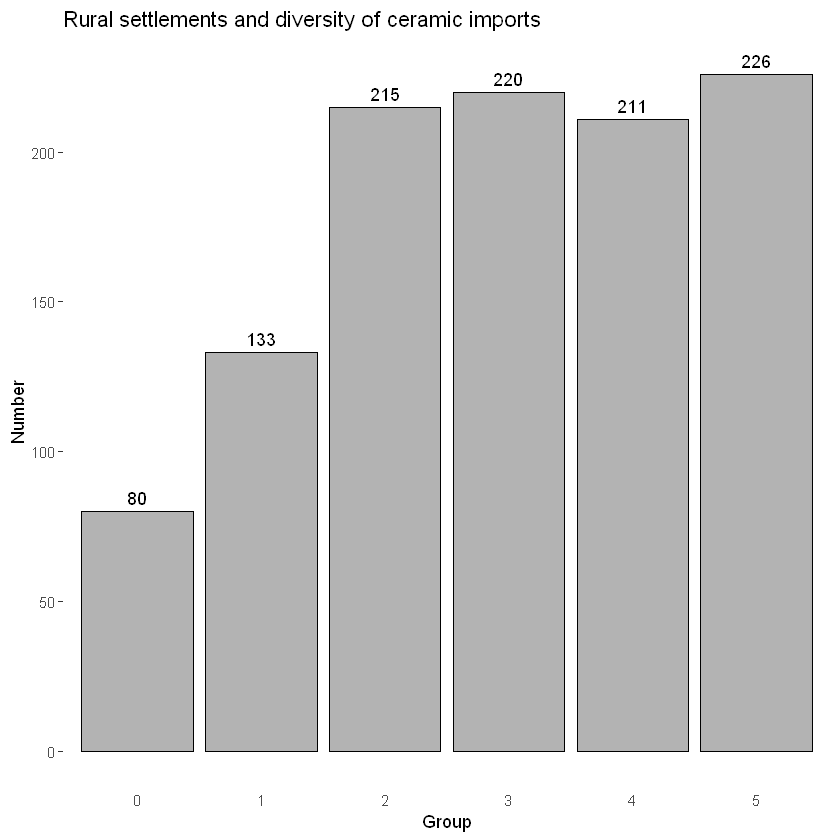

In [9]:
# script imp_var.R

# count diversity of ceramic imports 

var_cnt <- table(rural_imp$DIV_AWG)

# crosstabulate ceramic import classes and diversity

var_imp_tab <- table(rural_imp$IMP_GROUP, rural_imp$DIV_AWG)

# conver to proportional tables with horizontal and vertical marginals

prop_tab <- prop.table(var_imp_tab) 
prop_tab1 <- prop.table(var_imp_tab,1)
prop_tab2 <- prop.table(var_imp_tab,2)

# display in percentages 

t(prop_tab2) * 100

# calculate contingency coefficient and Cramer's V

chi <- chisq.test(var_imp_tab)
cont_coeff <- unname(sqrt(chi$statistic / (chi$statistic + sum(var_imp_tab))))

paste("Contingency coefficient: ", cont_coeff)

CramerV <- unname(sqrt((chi$statistic/sum(var_imp_tab))/min(nrow(var_imp_tab) - 1 ,ncol(var_imp_tab) - 1)))

paste("Cramer's V: ", CramerV)

# plot diversity of ceramic imports 

ggplot(as.data.frame(var_cnt), aes(Var1, Freq)) + 
  geom_col(fill="grey70", colour="black") +
  geom_text(aes(label = Freq, vjust = -0.5)) +
  ggtitle("Rural settlements and diversity of ceramic imports") +
  xlab("Group") +
  ylab("Number") + 
  theme(panel.background = element_rect(fill="white")) +
  theme(axis.ticks.x=element_blank())


## 8.2 Final classification

The final classes for the rural settlements (Section 3, Table 9 and Figure 9) are listed in the file [HCLASS_RURAL.txt](./HCLASS_RURAL.txt).

The results were mapped in QGIS (Section 5, Figure 11).

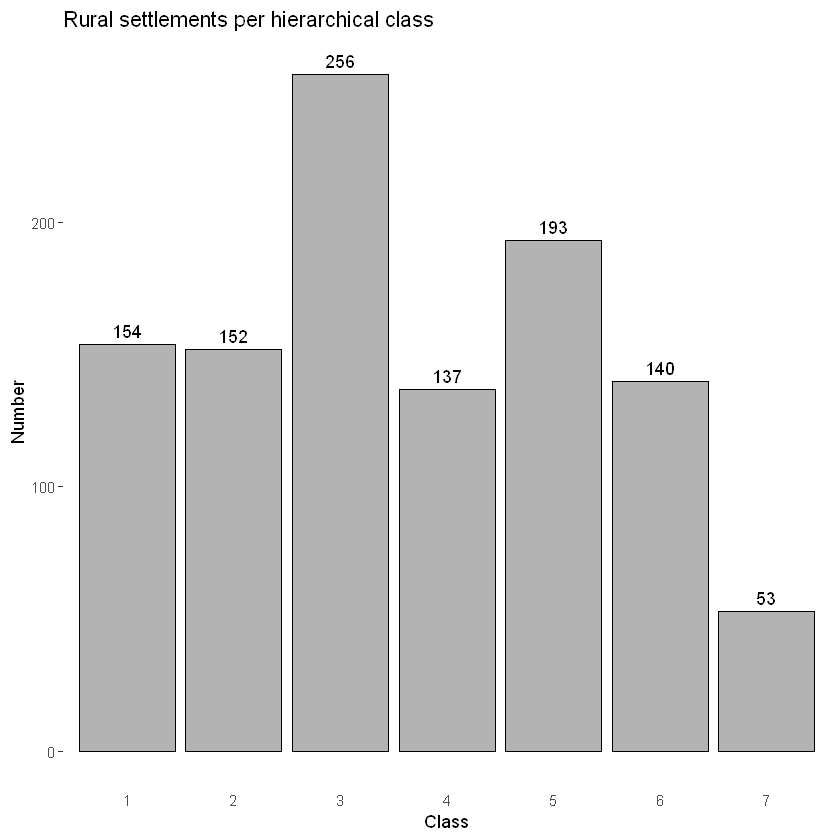

In [10]:
# script hclass_cnt.R

# read the datafile

HCLASS_RURAL <- read.csv("./HCLASS_RURAL.txt", header=TRUE, sep=";")

# tabulate the totals per group

hclass_cnt <- table(HCLASS_RURAL$HCLASS)

# plot the results

ggplot(as.data.frame(hclass_cnt), aes(Var1, Freq)) + 
  geom_col(fill="grey70", colour="black") +
  geom_text(aes(label = Freq, vjust = -0.5)) +
  ggtitle("Rural settlements per hierarchical class") +
  xlab("Class") +
  ylab("Number") + 
  theme(panel.background = element_rect(fill="white")) +
  theme(axis.ticks.x=element_blank())

## 8.3 Hierarchical range and diversity

The rural settlements were then analysed for hierarchical range and diversity by calculating means and standard deviations of hierarchical rank within three different radii (1500, 3000 and 9000 m). The results can be found in the files [HCLASS_1500.txt](./HCLASS_1500.txt), [HCLASS_3000.txt](./HCLASS_3000.txt) and [HCLASS_9000.txt](./HCLASS_9000.txt). The radius calculations were done through SQL querying. The results were then statistically analysed in R (presented here only for the 1500 m case; Figure 12, Tables 13 and 14) and mapped in QGIS (Figures 13 and 14).

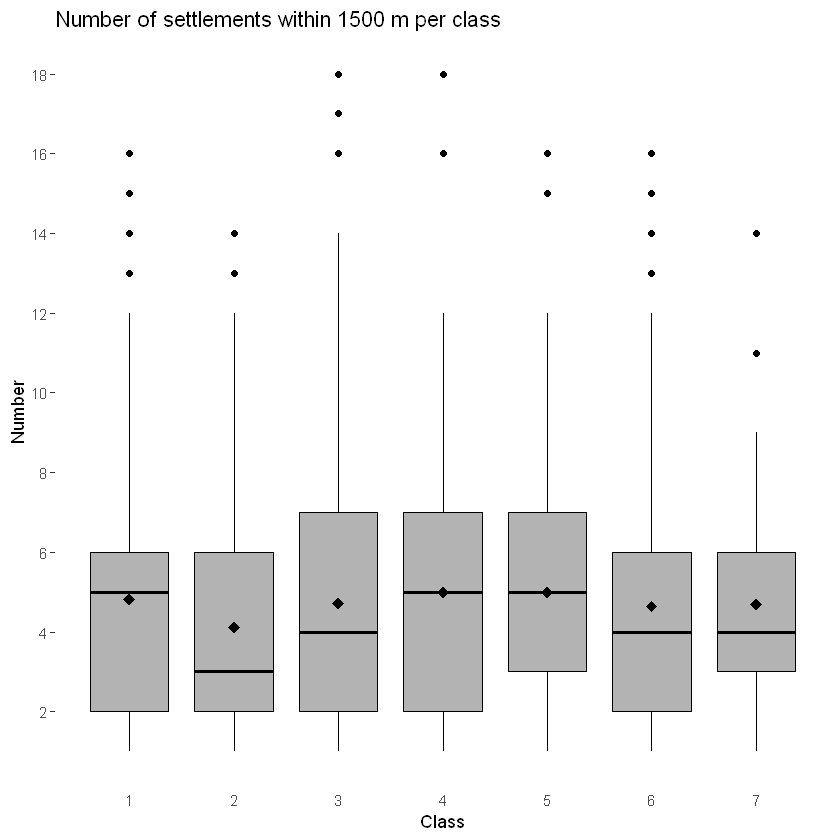

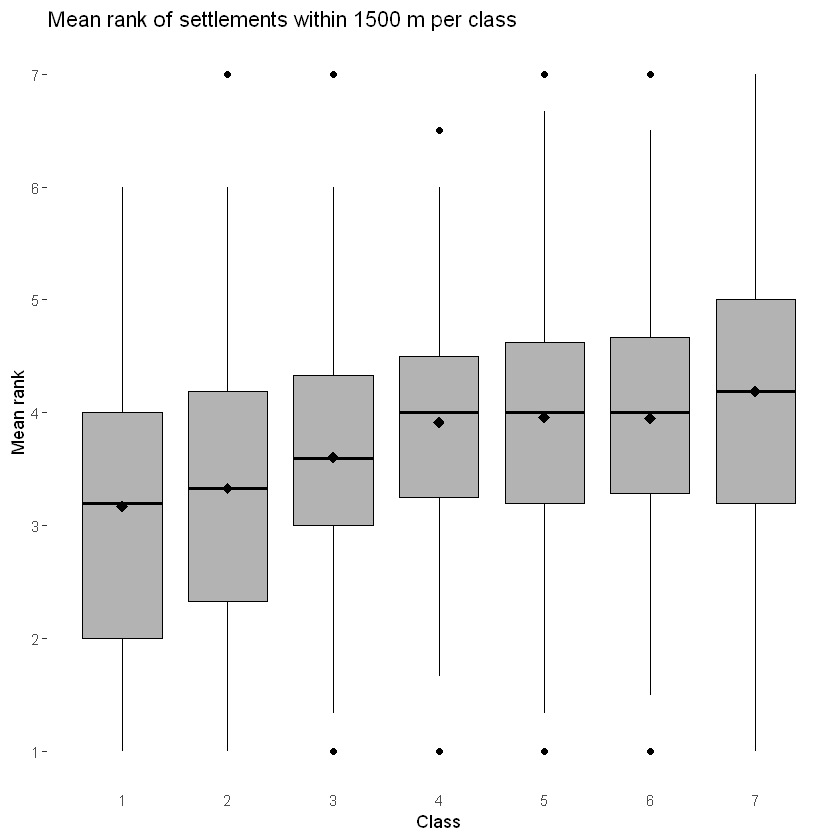

                                  Df Sum Sq Mean Sq F value Pr(>F)
as.factor(hrank_all_cnt$hclass)    6     75   12.56   1.251  0.278
Residuals                       1012  10162   10.04               

                                   Df Sum Sq Mean Sq F value   Pr(>F)    
as.factor(hrank_all_mean$hclass)    6  100.1  16.686   12.47 1.35e-13 ***
Residuals                        1012 1353.9   1.338                     
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

                                 Df Sum Sq Mean Sq F value Pr(>F)
as.factor(hrank_all_std$hclass)   6    4.0  0.6691   1.469  0.186
Residuals                       860  391.8  0.4556               
152 observations deleted due to missingness

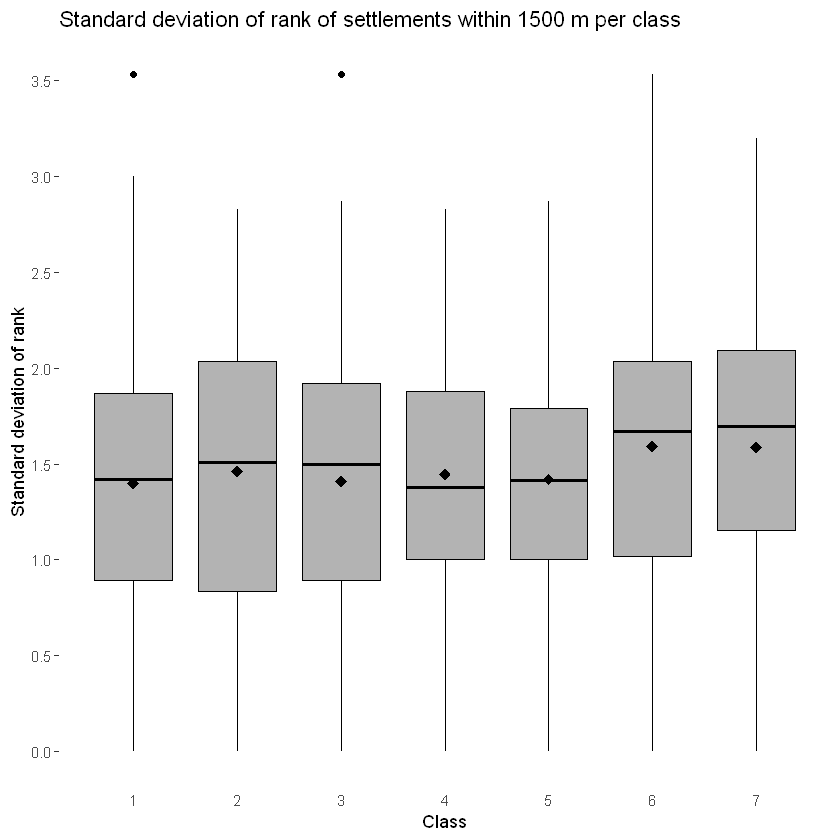

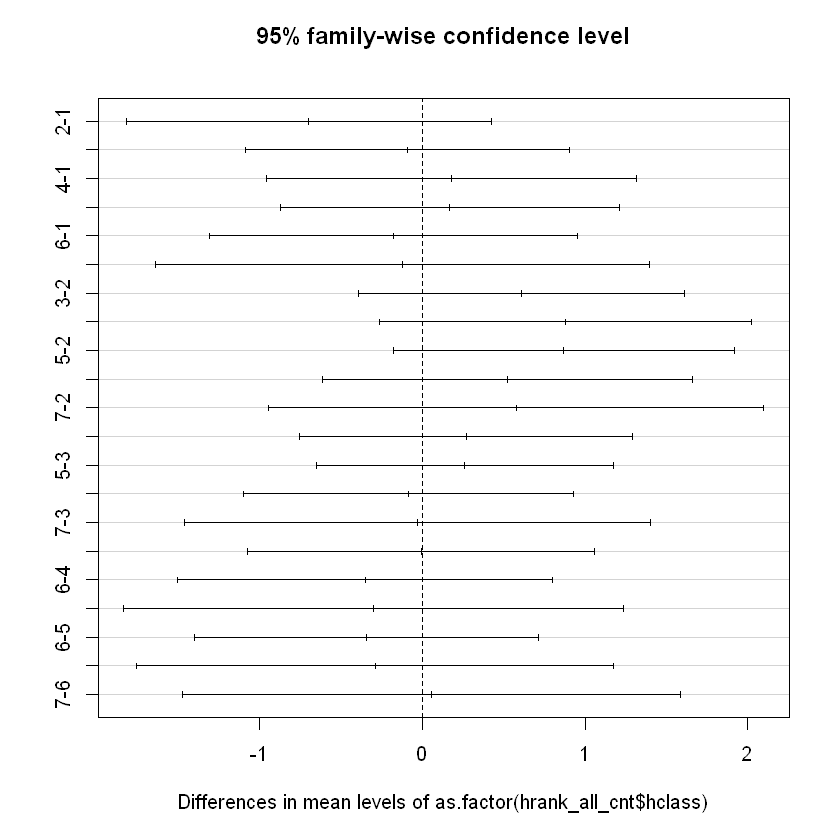

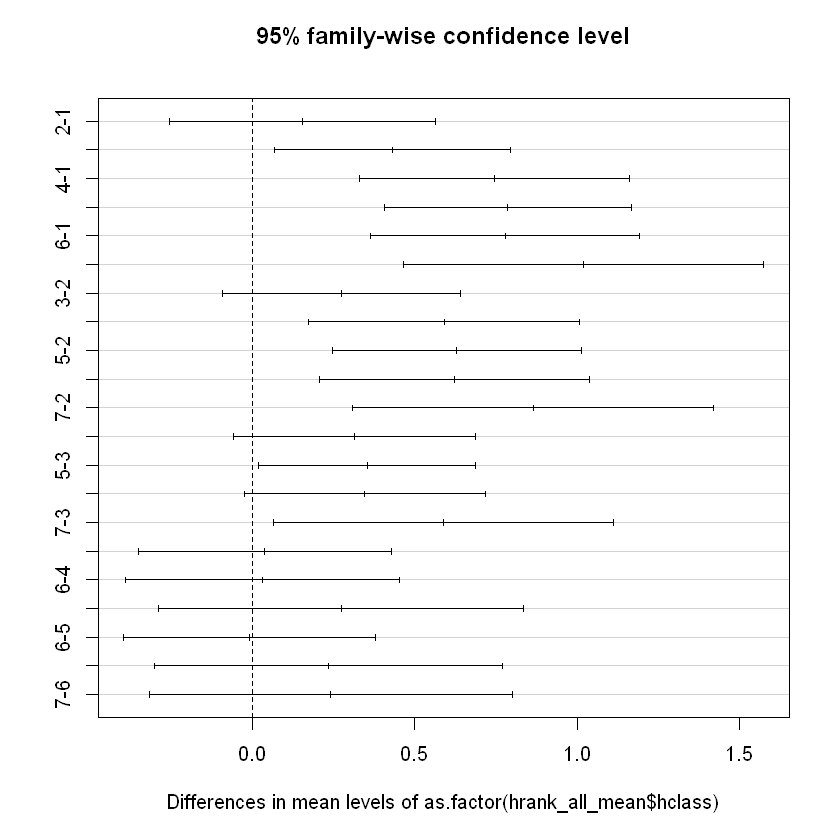

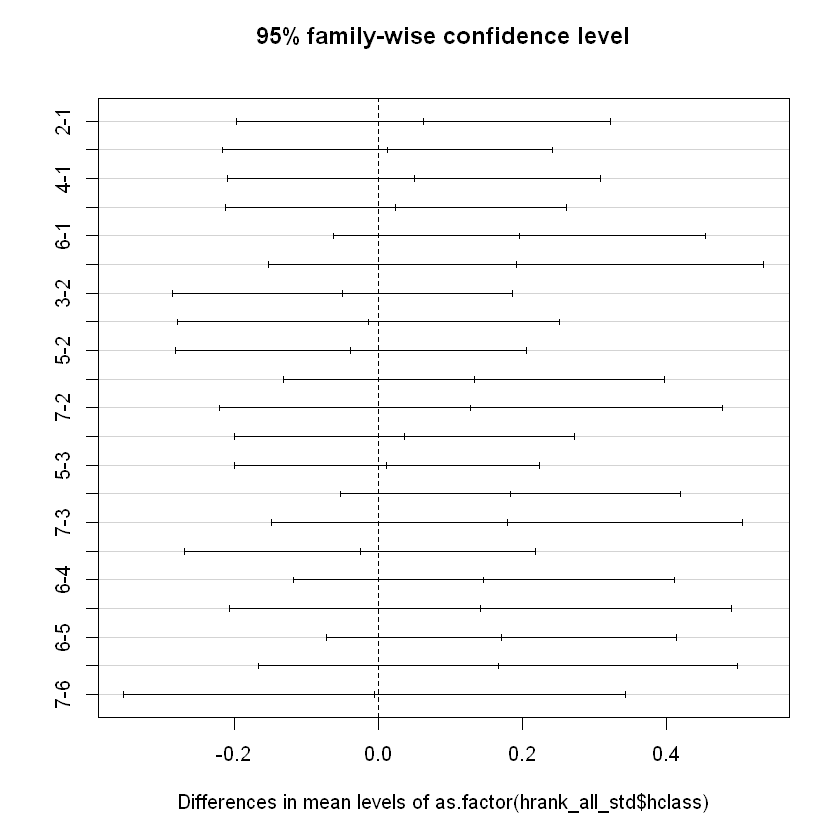

In [11]:
# script hclass_1500.R

# read the datafile

HCLASS_1500 <- read.csv("./HCLASS_1500.txt", header=TRUE, sep=";")

# first select all rural settlements using the data.table() package

rural_hc1500 <- subset(HCLASS_1500, Site_type %like% "rural" & HCLASS_2 < 8)

# extract the data per class, and calculate the statistics (number of settlements, mean and standard deviation of class rank)
# and bind it all back together

hrank_1 <- subset(rural_hc1500, HCLASS_1 == 1)
hrank_2 <- subset(rural_hc1500, HCLASS_1 == 2)
hrank_3 <- subset(rural_hc1500, HCLASS_1 == 3)
hrank_4 <- subset(rural_hc1500, HCLASS_1 == 4)
hrank_5 <- subset(rural_hc1500, HCLASS_1 == 5)
hrank_6 <- subset(rural_hc1500, HCLASS_1 == 6)
hrank_7 <- subset(rural_hc1500, HCLASS_1 == 7)

hrank_1_cnt <- aggregate(hrank_1$HCLASS_2, list(hrank_1$LimesLimits_ID_1), length)
hrank_2_cnt <- aggregate(hrank_2$HCLASS_2, list(hrank_2$LimesLimits_ID_1), length)
hrank_3_cnt <- aggregate(hrank_3$HCLASS_2, list(hrank_3$LimesLimits_ID_1), length)
hrank_4_cnt <- aggregate(hrank_4$HCLASS_2, list(hrank_4$LimesLimits_ID_1), length)
hrank_5_cnt <- aggregate(hrank_5$HCLASS_2, list(hrank_5$LimesLimits_ID_1), length)
hrank_6_cnt <- aggregate(hrank_6$HCLASS_2, list(hrank_6$LimesLimits_ID_1), length)
hrank_7_cnt <- aggregate(hrank_7$HCLASS_2, list(hrank_7$LimesLimits_ID_1), length)

hrank_1_cnt$hclass <- 1
hrank_2_cnt$hclass <- 2
hrank_3_cnt$hclass <- 3
hrank_4_cnt$hclass <- 4
hrank_5_cnt$hclass <- 5
hrank_6_cnt$hclass <- 6
hrank_7_cnt$hclass <- 7

hrank_all_cnt <- rbind(hrank_1_cnt,hrank_2_cnt,hrank_3_cnt,hrank_4_cnt,hrank_5_cnt,hrank_6_cnt,hrank_7_cnt)

hrank_1_mean <- aggregate(hrank_1$HCLASS_2, list(hrank_1$LimesLimits_ID_1), mean)
hrank_2_mean <- aggregate(hrank_2$HCLASS_2, list(hrank_2$LimesLimits_ID_1), mean)
hrank_3_mean <- aggregate(hrank_3$HCLASS_2, list(hrank_3$LimesLimits_ID_1), mean)
hrank_4_mean <- aggregate(hrank_4$HCLASS_2, list(hrank_4$LimesLimits_ID_1), mean)
hrank_5_mean <- aggregate(hrank_5$HCLASS_2, list(hrank_5$LimesLimits_ID_1), mean)
hrank_6_mean <- aggregate(hrank_6$HCLASS_2, list(hrank_6$LimesLimits_ID_1), mean)
hrank_7_mean <- aggregate(hrank_7$HCLASS_2, list(hrank_7$LimesLimits_ID_1), mean)

hrank_1_mean$hclass <- 1
hrank_2_mean$hclass <- 2
hrank_3_mean$hclass <- 3
hrank_4_mean$hclass <- 4
hrank_5_mean$hclass <- 5
hrank_6_mean$hclass <- 6
hrank_7_mean$hclass <- 7

hrank_all_mean <- rbind(hrank_1_mean,hrank_2_mean,hrank_3_mean,hrank_4_mean,hrank_5_mean,hrank_6_mean,hrank_7_mean)

hrank_1_std <- aggregate(hrank_1$HCLASS_2, list(hrank_1$LimesLimits_ID_1), sd)
hrank_2_std <- aggregate(hrank_2$HCLASS_2, list(hrank_2$LimesLimits_ID_1), sd)
hrank_3_std <- aggregate(hrank_3$HCLASS_2, list(hrank_3$LimesLimits_ID_1), sd)
hrank_4_std <- aggregate(hrank_4$HCLASS_2, list(hrank_4$LimesLimits_ID_1), sd)
hrank_5_std <- aggregate(hrank_5$HCLASS_2, list(hrank_5$LimesLimits_ID_1), sd)
hrank_6_std <- aggregate(hrank_6$HCLASS_2, list(hrank_6$LimesLimits_ID_1), sd)
hrank_7_std <- aggregate(hrank_7$HCLASS_2, list(hrank_7$LimesLimits_ID_1), sd)

hrank_1_std$hclass <- 1
hrank_2_std$hclass <- 2
hrank_3_std$hclass <- 3
hrank_4_std$hclass <- 4
hrank_5_std$hclass <- 5
hrank_6_std$hclass <- 6
hrank_7_std$hclass <- 7

hrank_all_std <- rbind(hrank_1_std,hrank_2_std,hrank_3_std,hrank_4_std,hrank_5_std,hrank_6_std,hrank_7_std)

# plot the results

ggplot(hrank_all_cnt, aes(x = hclass, y = x, group = hclass)) +
  geom_boxplot(fill="grey70", colour="black") +
  stat_summary(fun=mean, shape=18, colour="black", size=3, geom="point") +
  ggtitle("Number of settlements within 1500 m per class") +
  xlab("Class") +
  ylab("Number") +
  scale_x_continuous(breaks=seq(1,7,1)) +
  scale_y_continuous(breaks=seq(0,20,2)) +
  theme(panel.background = element_rect(fill="white")) +
  theme(axis.ticks.x=element_blank())

ggplot(hrank_all_mean, aes(x = hclass, y = x, group = hclass)) +
  geom_boxplot(fill="grey70", colour="black") +
  stat_summary(fun=mean, shape=18, colour="black", size=3, geom="point") +
  ggtitle("Mean rank of settlements within 1500 m per class") +
  xlab("Class") +
  ylab("Mean rank") +
  scale_x_continuous(breaks=seq(1,7,1)) +
  scale_y_continuous(breaks=seq(0,7,1)) +
  theme(panel.background = element_rect(fill="white")) +
  theme(axis.ticks.x=element_blank())

ggplot(hrank_all_std, aes(x = hclass, y = x, group = hclass)) +
  geom_boxplot(fill="grey70", colour="black") +
  stat_summary(fun=mean, shape=18, colour="black", size=3, geom="point") +
  ggtitle("Standard deviation of rank of settlements within 1500 m per class") +
  xlab("Class") +
  ylab("Standard deviation of rank") +
  scale_x_continuous(breaks=seq(1,7,1)) +
  scale_y_continuous(breaks=seq(0,4,0.5)) +
  theme(panel.background = element_rect(fill="white")) +
  theme(axis.ticks.x=element_blank())

# calculate the ANOVA and plot Tukey's HSD test

summary(aov(hrank_all_cnt$x ~ as.factor(hrank_all_cnt$hclass)))
summary(aov(hrank_all_mean$x ~ as.factor(hrank_all_mean$hclass)))
summary(aov(hrank_all_std$x ~ as.factor(hrank_all_std$hclass)))

plot(TukeyHSD(aov(hrank_all_cnt$x ~ as.factor(hrank_all_cnt$hclass))))
plot(TukeyHSD(aov(hrank_all_mean$x ~ as.factor(hrank_all_mean$hclass))))
plot(TukeyHSD(aov(hrank_all_std$x ~ as.factor(hrank_all_std$hclass))))

## 8.4 Settlement duration

Cross-tabulation of duration and imports is listed in [DUR_IMP.txt](./DUR_IMP.txt) (Section 4, Table 12 and Figure 10).

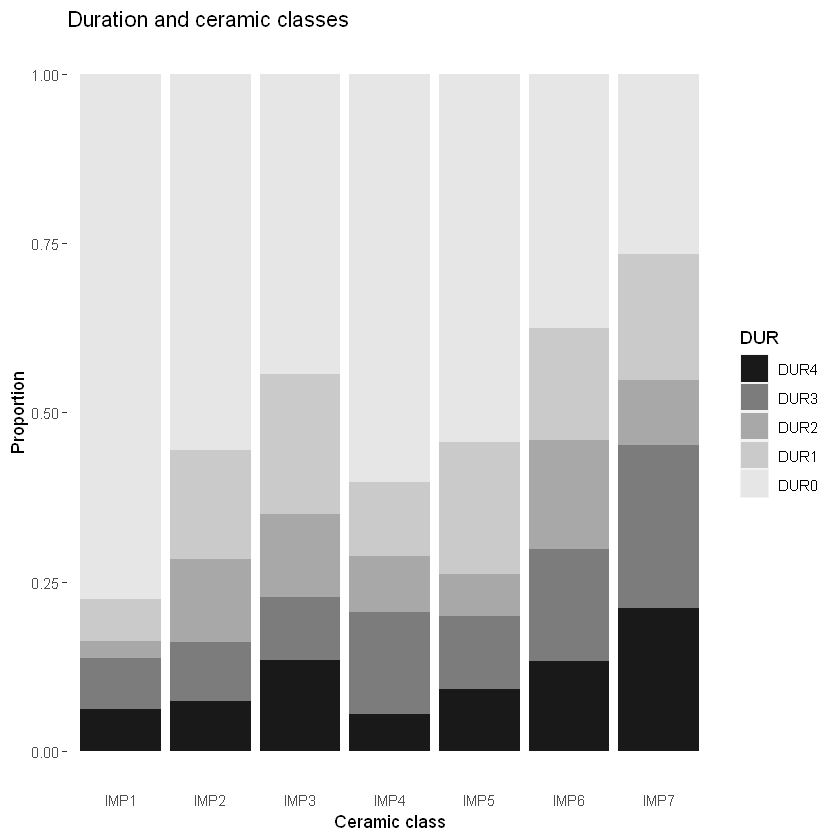

In [12]:
# script imp_dur.R

# read the datafile

imp_dur <- read.csv("./IMP_DUR.txt", header=TRUE, sep=";")

# plot the graph

ggplot(imp_dur, aes(x = IMP, y = FRQ, fill = DUR)) + 
  geom_bar(position = "fill", stat='identity') +
  guides(fill = guide_legend(reverse=TRUE)) +
  scale_fill_grey(start = 0.9, end = 0.1) +
  ggtitle("Duration and ceramic classes") +
  xlab("Ceramic class") +
  ylab("Proportion") + 
  theme(panel.background = element_rect(fill="white")) +
  theme(axis.ticks.x=element_blank())

## 8.5 Palaeogeography

Overlay of the settlements on the palaeographical map allowed to analyze the distribution of hierarchical ranges over the palaeogeographical units [HCLASS_PG_1500.txt](./HCLASS_PG_1500.txt). The palaeogeographical units were somewhat simplified in order to allow easier comparison (Section 5, Figure 15).

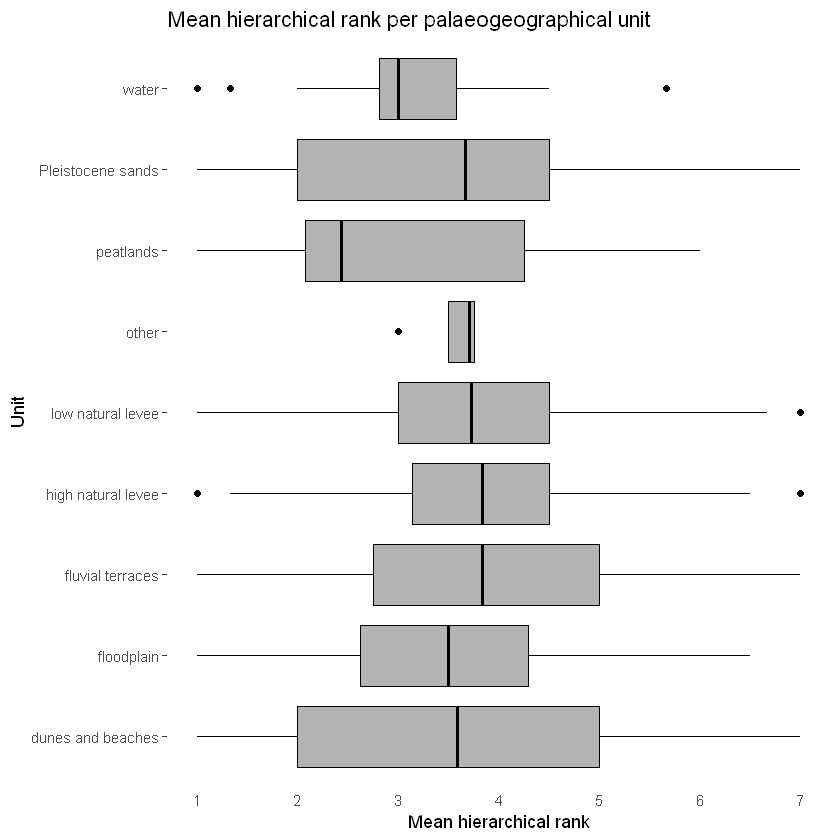

In [13]:
# script hclass_pg_1500.R

# read the datafile

HCLASS_PG <- read.csv("./HCLASS_PG_1500.txt", header=TRUE, sep=";")

# plot the results

ggplot(HCLASS_PG, aes(x = Totals_1500m_Nb_mean, y = Palaeogeography_simplified, group = Palaeogeography_simplified)) + 
  geom_boxplot(fill="grey70", colour="black") +
  ggtitle("Mean hierarchical rank per palaeogeographical unit") +
  xlab("Mean hierarchical rank") +
  ylab("Unit") +
  scale_x_continuous(breaks=seq(0,7,1)) +
  theme(panel.background = element_rect(fill="white")) +
  theme(axis.ticks.x=element_blank())

## 8.6 Urban settlements

The comparison between the urban and rural settlements (Section 5, Figure 16) was made as follows.

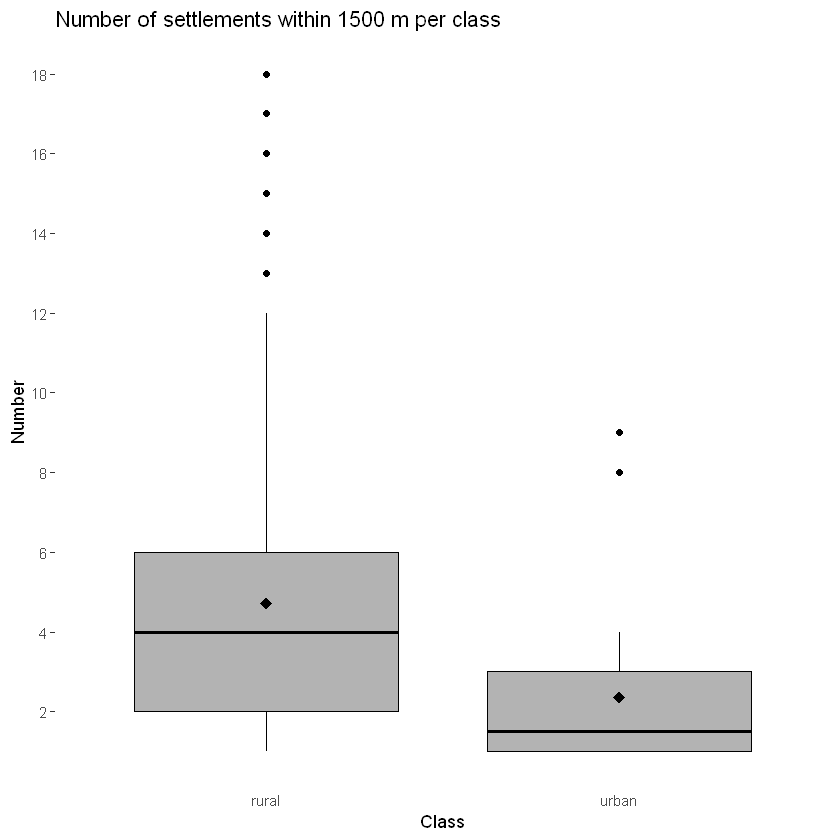

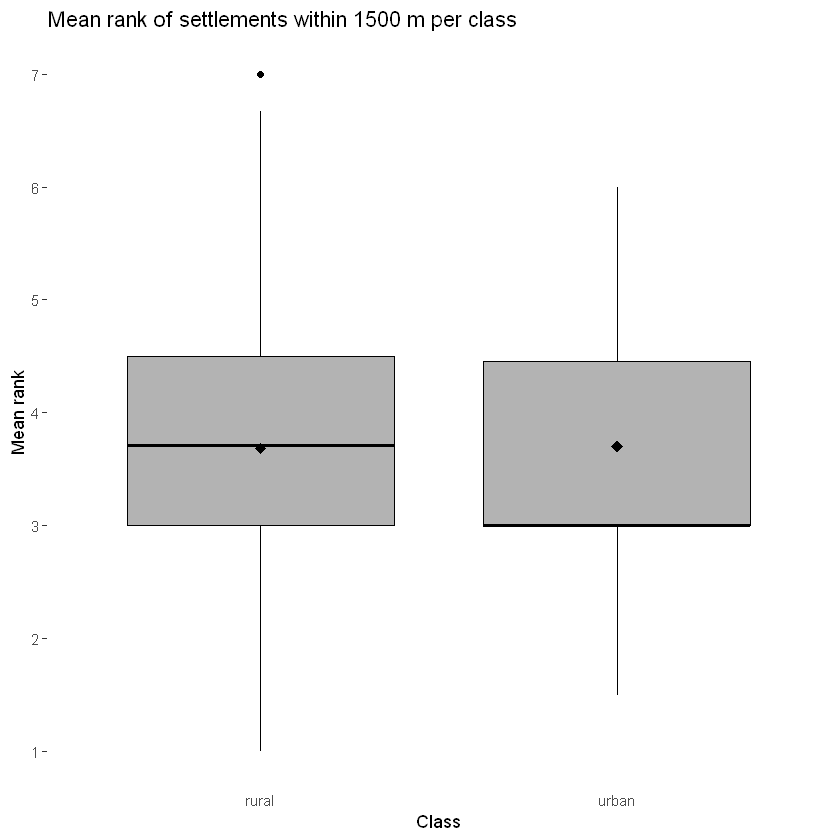

                                  Df Sum Sq Mean Sq F value   Pr(>F)    
as.factor(hrank_all_cnt$hclass)    1    185  185.01    18.7 1.67e-05 ***
Residuals                       1051  10395    9.89                     
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

                                   Df Sum Sq Mean Sq F value Pr(>F)
as.factor(hrank_all_mean$hclass)    1      0   0.007   0.005  0.944
Residuals                        1051   1518   1.445               

                                 Df Sum Sq Mean Sq F value Pr(>F)
as.factor(hrank_all_std$hclass)   1    0.6  0.5794    1.24  0.266
Residuals                       882  412.1  0.4673               
169 observations deleted due to missingness

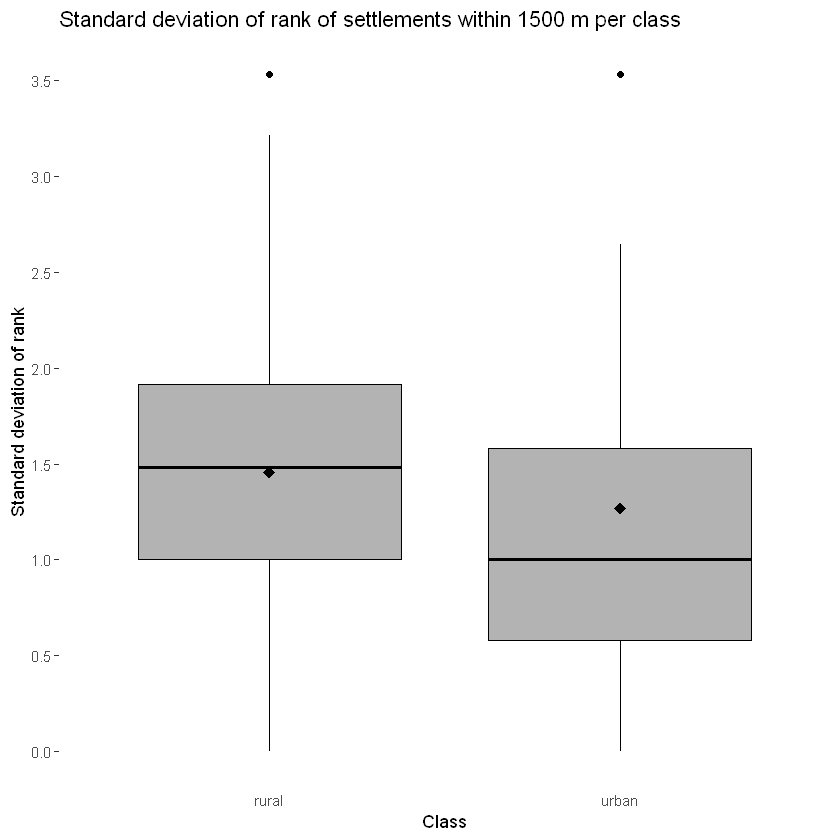

In [14]:
# script hclass_urb.R

# extract the data per class, and calculate the statistics (number of settlements, mean and standard deviation of class rank)
# and bind it all back together

urban_hc1500 <- subset(HCLASS_1500, HCLASS_1 > 7 & HCLASS_2 < 8)
rural_hc1500 <- subset(HCLASS_1500, Site_type %like% "rural" & HCLASS_2 < 8)

hrank_urban_cnt <- aggregate(urban_hc1500$HCLASS_2, list(urban_hc1500$LimesLimits_ID_1), length)
hrank_rural_cnt <- aggregate(rural_hc1500$HCLASS_2, list(rural_hc1500$LimesLimits_ID_1), length)

hrank_urban_cnt$hclass <- "urban"
hrank_rural_cnt$hclass <- "rural"

hrank_all_cnt <- rbind(hrank_urban_cnt,hrank_rural_cnt)

hrank_urban_mean <- aggregate(urban_hc1500$HCLASS_2, list(urban_hc1500$LimesLimits_ID_1), mean)
hrank_rural_mean <- aggregate(rural_hc1500$HCLASS_2, list(rural_hc1500$LimesLimits_ID_1), mean)

hrank_urban_mean$hclass <- "urban"
hrank_rural_mean$hclass <- "rural"

hrank_all_mean <- rbind(hrank_urban_mean,hrank_rural_mean)

hrank_urban_std <- aggregate(urban_hc1500$HCLASS_2, list(urban_hc1500$LimesLimits_ID_1), sd)
hrank_rural_std <- aggregate(rural_hc1500$HCLASS_2, list(rural_hc1500$LimesLimits_ID_1), sd)

hrank_urban_std$hclass <- "urban"
hrank_rural_std$hclass <- "rural"

hrank_all_std <- rbind(hrank_urban_std,hrank_rural_std)

# plot the results

ggplot(hrank_all_cnt, aes(x = hclass, y = x, group = hclass)) +
  geom_boxplot(fill="grey70", colour="black") +
  stat_summary(fun=mean, shape=18, colour="black", size=3, geom="point") +
  ggtitle("Number of settlements within 1500 m per class") +
  xlab("Class") +
  ylab("Number") +
#  scale_x_continuous(breaks=seq(1,7,1)) +
  scale_y_continuous(breaks=seq(0,20,2)) +
  theme(panel.background = element_rect(fill="white")) +
  theme(axis.ticks.x=element_blank())

ggplot(hrank_all_mean, aes(x = hclass, y = x, group = hclass)) +
  geom_boxplot(fill="grey70", colour="black") +
  stat_summary(fun=mean, shape=18, colour="black", size=3, geom="point") +
  ggtitle("Mean rank of settlements within 1500 m per class") +
  xlab("Class") +
  ylab("Mean rank") +
#  scale_x_continuous(breaks=seq(1,7,1)) +
  scale_y_continuous(breaks=seq(0,7,1)) +
  theme(panel.background = element_rect(fill="white")) +
  theme(axis.ticks.x=element_blank())

ggplot(hrank_all_std, aes(x = hclass, y = x, group = hclass)) +
  geom_boxplot(fill="grey70", colour="black") +
  stat_summary(fun=mean, shape=18, colour="black", size=3, geom="point") +
  ggtitle("Standard deviation of rank of settlements within 1500 m per class") +
  xlab("Class") +
  ylab("Standard deviation of rank") +
#  scale_x_continuous(breaks=seq(1,7,1)) +
  scale_y_continuous(breaks=seq(0,4,0.5)) +
  theme(panel.background = element_rect(fill="white")) +
  theme(axis.ticks.x=element_blank())

# calculate the ANOVA

summary(aov(hrank_all_cnt$x ~ as.factor(hrank_all_cnt$hclass)))
summary(aov(hrank_all_mean$x ~ as.factor(hrank_all_mean$hclass)))
summary(aov(hrank_all_std$x ~ as.factor(hrank_all_std$hclass)))

# 9. References

Baddeley, A. 2022. Package 'spatstat'. https://cran.r-project.org/web/packages/spatstat/spatstat.pdf

Groenhuijzen, M.R. 2018. <i>Palaeogeographic Analysis of the Dutch Part of the Roman Limes and Its Hinterland</i>. Amsterdam: Vrije Universiteit Amsterdam.

Maddison, M.S., and S.C. Schmidt. 2020. ‘Percolation Analysis – Archaeological Applications at Widely Different Spatial Scales’. <i>Journal of Computer Applications in Archaeology</i> 3 (1): 269–87. https://doi.org/10.5334/jcaa.54.

Verhagen, P., I. Vossen, M.R. Groenhuijzen, and J. Joyce. 2016. ‘Now You See Them, Now You Don’t: Defining and Using a Flexible Chronology of Sites for Spatial Analysis of Roman Settlement in the Dutch River Area’. <i>Journal of Archaeological Science: Reports</i> 10: 309–21. https://doi.org/10.1016/j.jasrep.2016.10.006.

Verhagen, P., J. Joyce, and M.R. Groenhuijzen. 2019. ‘Finding the Limits of the Limes: Setting the Scene’. In <i>Finding the Limits of the Limes</i>, edited by P. Verhagen, J. Joyce, and M.R. Groenhuijzen, 1–19. Computational Social Sciences. Cham: Springer International Publishing. https://doi.org/10.1007/978-3-030-04576-0_1.
